# how many novel lncRNAs are quantified?

evidence that the new lncRNAs are expressed/quantifiable in v10 vs v11.

v10 used gencode 46 with 19000 lncRNAs, v11 uses gencode 47 with 35000 lncRNAs

In [260]:
import pandas as pd
import seaborn as sns
import pyranges as pr
import numpy as np
import matplotlib.pyplot as plt
import upsetplot as up
from matplotlib.colors import hex2color
from scipy.stats.kde import gaussian_kde
from scipy.stats import norm
from matplotlib.colors import LogNorm

import os

/local/scratch/klawren/slrmtmp.47767837/ipykernel_29522/579307499.py:8: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  from scipy.stats.kde import gaussian_kde


In [127]:
gencode_v39_path = "/home/klawren/oak/gtex/data/references/old_gencode/gencode.v39.annotation.gtf"
gencode_v47_path = "/home/klawren/oak/gtex/data/references/gencode.v47.annotation.gtf"

v10_quantificaiton_path = "/home/klawren/oak/gtex/data/references/old_gencode/gene_tpm_v10_brain_caudate_basal_ganglia.gct.gz"
v11_quantificaiton_dir = "/home/klawren/oak/gtex/test_workflow/output_kate/"

### comparison of gencode annotations

In [128]:
# load in gencode for lncRNA annotations
gencode_v39=pr.read_gtf(gencode_v39_path).as_df()
gencode_v47=pr.read_gtf(gencode_v47_path).as_df()

In [129]:
# drop duplicates (multiple transcripts of same gene)
gencode_v39 = gencode_v39.drop_duplicates('gene_id')
gencode_v47 = gencode_v47.drop_duplicates('gene_id')

In [130]:
# harmonize annotation categories as in https://www.gencodegenes.org/pages/biotypes.html
gencode_v39['gene_type_harmonized'] = np.where(gencode_v39['gene_type'].isin(['3prime_overlapping_ncRNA', 'antisense', 'bidirectional_promoter_lncRNA', 'lincRNA', 'macro_lncRNA', 'non_coding', 'processed_transcript', 'sense_intronic','sense_overlapping']), 'lncRNA', gencode_v39['gene_type'])
gencode_v39['gene_type_harmonized'] = np.where(gencode_v39['gene_type_harmonized'].isin(['vaultRNA']), 'vault_RNA', gencode_v39['gene_type_harmonized'])

In [131]:
gene_type_counts = pd.DataFrame({'v47':gencode_v47.groupby('gene_type').size(), 'v39':gencode_v39.groupby('gene_type_harmonized').size()}).reset_index(names='gene_type')
gene_type_melt = gene_type_counts.melt(id_vars=['gene_type'], value_vars=['v47', 'v39'], value_name='count', var_name='version')

/local/scratch/klawren/slrmtmp.47767837/ipykernel_29522/3796981686.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


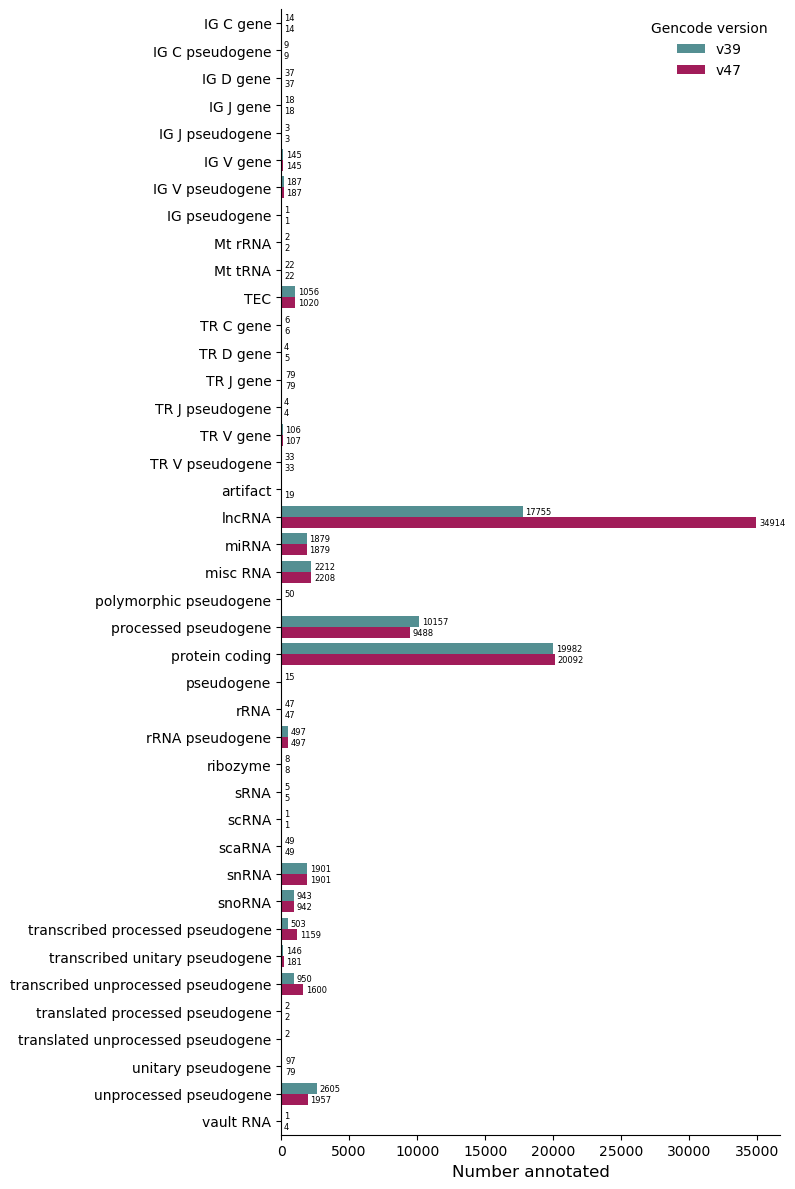

In [132]:
fig, ax = plt.subplots(figsize=(8,12))
sns.barplot(gene_type_melt, y='gene_type', hue='version', x='count', hue_order=['v39', 'v47'], ax=ax, palette=['#4a989c', '#b70657'])

#ax.set_xscale('log')

ax.set_xlabel('Number annotated', fontsize=12)
ax.set_ylabel('')
ax.spines[['top', 'right']].set_visible(False)

# add numbers to plot
for container in ax.containers:
    ax.bar_label(container, padding=2, fontsize=6)

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

# legend
legend = ax.get_legend()
legend.get_frame().set_visible(False)
legend.set_title("Gencode version")

plt.tight_layout() 
plt.show()

In [133]:
# group some categories 
def group_gene_type(gencode_df):
    gencode_df['gene_type_grouped'] = np.where(gencode_df['gene_type_harmonized'].isin(['Mt_rRNA',
                                                                                            'Mt_tRNA',
                                                                                            'miRNA',
                                                                                            'misc_RNA',
                                                                                            'rRNA',
                                                                                            'scRNA',
                                                                                            'snRNA',
                                                                                            'snoRNA',
                                                                                            'ribozyme',
                                                                                            'sRNA',
                                                                                            'scaRNA',
                                                                                            'vault_RNA']), 'noncoding_RNA', gencode_df['gene_type_harmonized'])

    gencode_df['gene_type_grouped'] = np.where(gencode_df['gene_type_harmonized'].isin(['Mt_tRNA_pseudogene',
                                                                                            'tRNA_pseudogene',
                                                                                            'snoRNA_pseudogene',
                                                                                            'snRNA_pseudogene',
                                                                                            'scRNA_pseudogene',
                                                                                            'rRNA_pseudogene',
                                                                                            'misc_RNA_pseudogene',
                                                                                            'miRNA_pseudogene']), 'noncoding_RNA_pseudogene', gencode_df['gene_type_grouped'])
    

    gencode_df['gene_type_grouped'] = np.where(gencode_df['gene_type_grouped'].isin(['noncoding_RNA_pseudogene']),'noncoding_RNA', gencode_df['gene_type_grouped'])

    gencode_df['gene_type_grouped'] = np.where(gencode_df['gene_type_harmonized'].isin(['transcribed_processed_pseudogene',
                                                                                            'transcribed_unprocessed_pseudogene',
                                                                                            'transcribed_unitary_pseudogene',
                                                                                            'translated_processed_pseudogene',
                                                                                            'translated_unprocessed_pseudogene',
                                                                                            'unitary_pseudogene',
                                                                                            'unprocessed_pseudogene',
                                                                                            'pseudogene',
                                                                                            'polymorphic_pseudogene',
                                                                                            'processed_pseudogene',
                                                                                            'IG_C_pseudogene', 
                                                                                            'IG_J_pseudogene', 
                                                                                            'IG_V_pseudogene', 
                                                                                            'IG_pseudogene',
                                                                                            'TR_V_pseudogene',
                                                                                            'TR_J_pseudogene']), 'pseudogene', gencode_df['gene_type_grouped'])
    
    gencode_df['gene_type_grouped'] = np.where(gencode_df['gene_type_harmonized'].isin(['protein_coding', 
                                                                                        'TEC',
                                                                                        'IG_C_gene', 
                                                                                        'IG_D_gene', 
                                                                                        'IG_J_gene',
                                                                                        'IG_V_gene', 
                                                                                        'TR_C_gene',
                                                                                        'TR_J_gene',
                                                                                        'TR_V_gene',
                                                                                        'TR_D_gene']), 'protien_coding_or_TEC', gencode_df['gene_type_grouped'])


In [134]:
gencode_v47['gene_type_harmonized'] = gencode_v47['gene_type']
group_gene_type(gencode_v47)
group_gene_type(gencode_v39)

gene_type_counts = pd.DataFrame({'v47':gencode_v47.groupby('gene_type_grouped').size(), 'v39':gencode_v39.groupby('gene_type_grouped').size()}).reset_index(names='gene_type')
gene_type_melt = gene_type_counts.melt(id_vars=['gene_type'], value_vars=['v47', 'v39'], value_name='count', var_name='version')

/local/scratch/klawren/slrmtmp.47767837/ipykernel_29522/3628803940.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


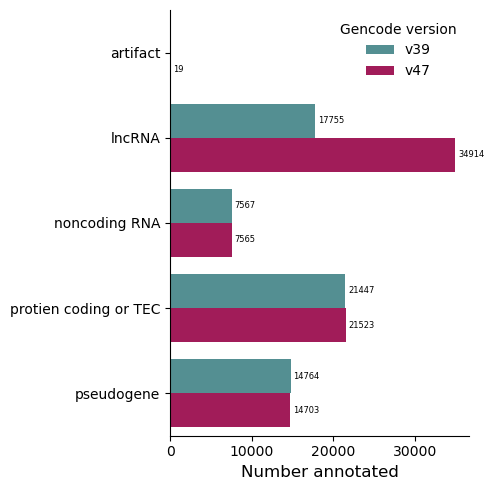

In [135]:
fig, ax = plt.subplots(figsize=(5,5))
sns.barplot(gene_type_melt, y='gene_type', hue='version', x='count', hue_order=['v39', 'v47'], ax=ax, palette=[ '#4a989c', '#b70657'])

ax.set_xlabel('Number annotated', fontsize=12)
ax.set_ylabel('')
ax.spines[['top', 'right']].set_visible(False)

# add numbers to plot
for container in ax.containers:
    ax.bar_label(container, padding=2, fontsize=6)

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

# legend
legend = ax.get_legend()
legend.get_frame().set_visible(False)
legend.set_title("Gencode version")

plt.tight_layout() 
plt.show()

### comparison of lnc RNAs we detect

In [136]:
tpm_cutoff=.1
gene_type_order = ['lncRNA', 'protien_coding_or_TEC', 'pseudogene', 'noncoding_RNA', 'artifact']

gene_type_pal = {'lncRNA':'#b70657',
                 'protien_coding_or_TEC':'#215B30',
                 'noncoding_RNA':'#6A5ACD',
                 'pseudogene':'#005BBF',
                 'artifact':'#7a7a7a'}


highlight_gene_type_pal = {'new_lncRNA':'#fb7cb6', 
                           'lncRNA':'#b70657',
                 'protien_coding_or_TEC':'#215B30',
                 'noncoding_RNA':'#6A5ACD',
                 'pseudogene':'#005BBF',
                 'artifact':'#7a7a7a'}

In [137]:
# aggregate quantifications from the output directory
# final output should be dataframe with sample_id as columns and gene_tpm

sample_tpms = []
for filename in os.listdir(os.path.join(v11_quantificaiton_dir, 'rnaseq_qc')):
        if filename.endswith('.gene_tpm.gct.gz'):
            print(filename)
            sample_tpms.append(pd.read_csv(os.path.join(v11_quantificaiton_dir, f'rnaseq_qc/{filename}'), sep='\t', skiprows=2).set_index(['Name', 'Description']))

tpm_v11 = pd.concat(sample_tpms, axis=1).reset_index()
tpm_v11.head()

GTEX-1NV5F-3226-SM-EXUSL.gene_tpm.gct.gz
GTEX-YFCO-0626-SM-HM8UJ.gene_tpm.gct.gz
GTEX-1C4CL-2126-SM-7IGQC.gene_tpm.gct.gz


,Name,Description,GTEX-1NV5F-3226-SM-EXUSL,GTEX-YFCO-0626-SM-HM8UJ,GTEX-1C4CL-2126-SM-7IGQC
0,ENSG00000290825.2,DDX11L16,0.000000,0.000000,0.000000
1,ENSG00000223972.6,DDX11L1,0.000000,0.000000,0.000000
2,ENSG00000310526.1,WASH7P,0.904932,1.217702,3.713216
3,ENSG00000243485.6,MIR1302-2HG,0.000000,0.000000,0.000000
4,ENSG00000237613.3,FAM138A,0.045423,0.000000,0.029986


In [138]:
# load in tpm quantification
tpm_v10 = pd.read_csv(v10_quantificaiton_path, sep='\t', skiprows=2)
# replace the sample ids to match the format in v11
tpm_v10.columns = tpm_v10.columns.str.replace('-R5a-', '', regex=False)
tpm_v10.head()

,Name,Description,GTEX-1117F-0011SM-GI4VW,GTEX-111FC-0011SM-GIN8L,GTEX-117XS-0011-R5b-SM-GJ3PP,GTEX-1192W-0011SM-GI4VY,GTEX-1192X-0011SM-DNZZA,GTEX-11DXW-0011-R5b-SM-DO11D,GTEX-11DXY-0011-R5b-SM-DNZZL,GTEX-11DYG-0011SM-DO928,...,GTEX-ZE9C-0011SM-5EGLO,GTEX-ZF28-0011SM-4WWCZ,GTEX-ZUA1-0011-R5b-SM-51MTG,GTEX-ZV68-0011SM-4YCDW,GTEX-ZVT3-0011SM-51MSI,GTEX-ZVZQ-0011-R5b-SM-57WDC,GTEX-ZXG5-0011-R5b-SM-57WBN,GTEX-ZYFD-0011SM-H6Q7M,GTEX-ZYY3-0011SM-H7OGH,GTEX-ZZPT-0011SM-GPRX5
0,ENSG00000223972.5,DDX11L1,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.033181,0.013432,0.010025,0.012049,0.025464
1,ENSG00000227232.5,WASH7P,3.51443,3.443050,2.843570,2.49813,2.098910,0.799514,2.53661,1.20675,...,0.774938,2.06256,1.604420,1.209580,1.01061,1.814390,1.923700,1.109440,1.302020,1.624510
2,ENSG00000278267.1,MIR6859-1,0.00000,0.365439,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
3,ENSG00000243485.5,MIR1302-2HG,0.00000,0.028695,0.057756,0.00000,0.058521,0.043787,0.00000,0.00000,...,0.086953,0.00000,0.119049,0.033725,0.00000,0.033123,0.000000,0.000000,0.024056,0.025420
4,ENSG00000237613.2,FAM138A,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,...,0.020591,0.00000,0.000000,0.047918,0.00000,0.023531,0.000000,0.000000,0.000000,0.000000


In [ ]:
# check v10 gene_ids are all in v39 gencode
print('{} v10 gene ids aren\'t in gencode v39'.format(sum(~tpm_v10['Name'].isin(gencode_v39['gene_id']))))
# check v11 gene_ids are all in v47 gencode
print('{} v11 gene ids aren\'t in gencode v47'.format(sum(~tpm_v11['Name'].isin(gencode_v47['gene_id']))))


0 v10 gene ids aren't in gencode v39
0 v11 gene ids aren't in gencode v47


In [194]:
# get mean tpm for v10
# curretly taking 3 to match the number of test samples
#TODO update this to be full samples when analyzing caudate
v10_sample_ids = tpm_v10.columns[2:][:3]

v10_mean_tpm = pd.DataFrame({'gene_id':tpm_v10['Name'], 'tpm':tpm_v10[v10_sample_ids].mean(axis=1)})
v10_mean_tpm = pd.merge(left=v10_mean_tpm, right=gencode_v39[['gene_id', 'gene_type_grouped']], on='gene_id', how='left')
v10_mean_tpm['quantified'] = v10_mean_tpm['tpm']>tpm_cutoff

Text(0.15000000000000002, 1765.2600000000002, 'quantified')

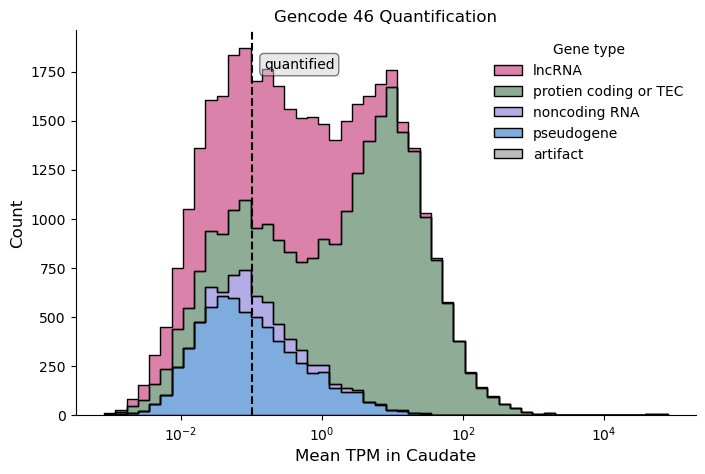

In [204]:
# v10 distribution
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(v10_mean_tpm, x='tpm', hue='gene_type_grouped', bins=50, log_scale=True, element='step', fill=True, ax=ax, palette=gene_type_pal, multiple='stack', alpha=.5,
             hue_order=list(highlight_gene_type_pal.keys())[1:])

ax.set_xlabel('Mean TPM in Caudate', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.spines[['top', 'right']].set_visible(False)
ax.set_title('Gencode 46 Quantification')


# Customize the legend
legend = ax.get_legend()
new_labels = [label.get_text().replace('_', ' ') for label in legend.texts]
for t, new_label in zip(legend.texts, new_labels):
    t.set_text(new_label)
legend.get_frame().set_visible(False)
legend.set_title("Gene type")

ax.axvline(tpm_cutoff, color='k', linestyle='--')
ax.text(tpm_cutoff+.05, ax.get_ylim()[1] * 0.9, 'quantified', horizontalalignment='left', fontsize=10, color='k', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightgrey', alpha=.5))
# ax.text(tpm_cutoff-.03, ax.get_ylim()[1] * 0.9, 'un-quantified', horizontalalignment='right', fontsize=10, color='k', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightgrey', alpha=.5))


In [196]:
# get v11 data
v11_sample_ids = tpm_v11.columns[2:]
v11_mean_tpm = pd.DataFrame({'gene_id':tpm_v11['Name'], 'tpm':tpm_v11[v11_sample_ids].mean(axis=1)})
v11_mean_tpm = pd.merge(left=v11_mean_tpm, right=gencode_v47[['gene_id', 'gene_type_grouped']], on='gene_id', how='left')

# get a list of the new lncRNAs
new_lncrnas = gencode_v47[gencode_v47['gene_type_grouped']=='lncRNA']['gene_id']
new_lncrnas = new_lncrnas[~new_lncrnas.isin(gencode_v39['gene_id'])]
# add info about new lncRNAs
v11_mean_tpm['new_highlight_gene_type'] = np.where(v11_mean_tpm['gene_id'].isin(new_lncrnas), 'new_lncRNA', v11_mean_tpm['gene_type_grouped'])
v11_mean_tpm['quantified'] = v11_mean_tpm['tpm']>tpm_cutoff

Text(0.15000000000000002, 2254.7700000000004, 'quantified')

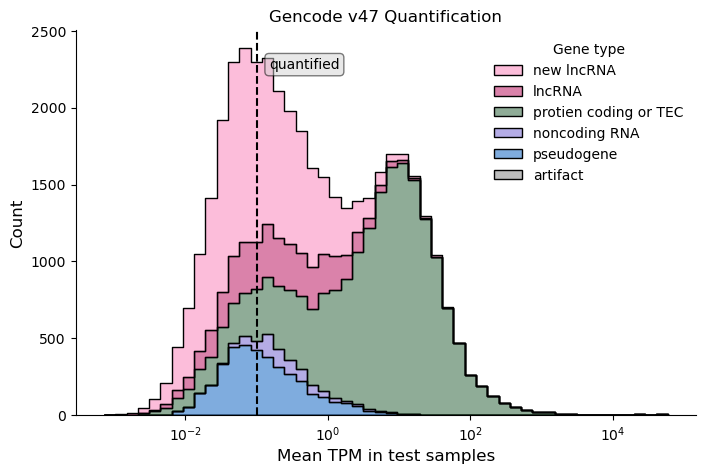

In [205]:
# v11 distribution
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(v11_mean_tpm, x='tpm', hue='new_highlight_gene_type', bins=50, log_scale=True, element='step', fill=True, ax=ax, palette=highlight_gene_type_pal, multiple='stack', alpha=.5,
             hue_order=list(highlight_gene_type_pal.keys()))

ax.set_xlabel('Mean TPM in test samples', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.spines[['top', 'right']].set_visible(False)
ax.set_title('Gencode v47 Quantification')

# Customize the legend
legend = ax.get_legend()
new_labels = [label.get_text().replace('_', ' ') for label in legend.texts]
for t, new_label in zip(legend.texts, new_labels):
    t.set_text(new_label)
legend.get_frame().set_visible(False)
legend.set_title("Gene type")

ax.axvline(tpm_cutoff, color='k', linestyle='--')
ax.text(tpm_cutoff+.05, ax.get_ylim()[1] * 0.9, 'quantified', horizontalalignment='left', fontsize=10, color='k', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightgrey', alpha=.5))
# ax.text(tpm_cutoff-.03, ax.get_ylim()[1] * 0.9, 'un-quantified', horizontalalignment='right', fontsize=10, color='k', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightgrey', alpha=.5))


In [208]:
# combine the two versions
mean_tpm_combined = pd.merge(left=v10_mean_tpm, right=v11_mean_tpm, on='gene_id', suffixes=['_v10', '_v11'], how='right')
mean_tpm_combined['quantified_v10'] = mean_tpm_combined['quantified_v10'].fillna(False)
# rename for upset plot
quantified_mean_tpm = mean_tpm_combined[(mean_tpm_combined['quantified_v10']) | (mean_tpm_combined['quantified_v11'])]
quantified_mean_tpm = quantified_mean_tpm.rename(columns={'quantified_v10':'v10','quantified_v11':'v11'})
upset_tpm_bool = quantified_mean_tpm.set_index('v10').set_index('v11', append=True)

dict_keys(['matrix', 'shading', 'totals', 'extra0'])


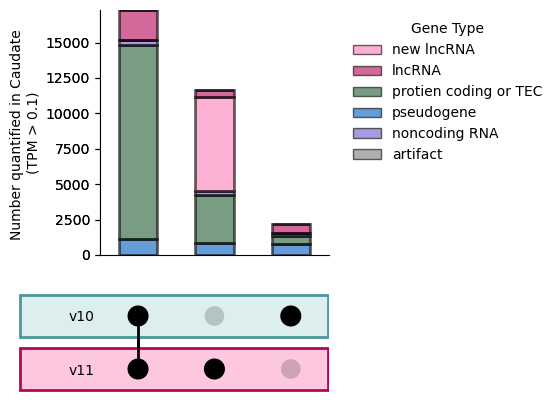

In [212]:
fig = plt.figure(figsize=(4,5))

upset = up.UpSet(upset_tpm_bool, intersection_plot_elements=0, totals_plot_elements=0, show_counts=False, element_size=None, sort_by="cardinality")  # disable the default bar chart
upset.add_stacked_bars(by="new_highlight_gene_type", title="", elements=4, colors=highlight_gene_type_pal, )
plot_result = upset.plot(fig=fig)

# add category colors
upset.style_categories("v10", shading_edgecolor='#4a989c', shading_linewidth=2, shading_facecolor='#ddeeef')
upset.style_categories("v11", shading_edgecolor='#b70657', shading_linewidth=2, shading_facecolor='#fdc7e0')

# style the instersection plot
plot_result = upset.plot(fig=fig)
print(plot_result.keys())

# style the stacked bar plot
stackedbar_plot = plot_result["extra0"]
stackedbar_plot.grid(False)
stackedbar_plot.set_ylabel("Number quantified in Caudate \n(TPM > 0.1)")
stackedbar_plot.spines['bottom'].set_visible(True)

# Customize the bars to have an alpha transparency and black outlines
for bar in stackedbar_plot.patches:
    bar.set_edgecolor('black')  # Add black edge outline
    bar.set_linewidth(2)  # Set the width of the edge outline
    bar.set_alpha(0.6)  # Set transparency
    
# optional add bar labels
# for container in stackedbar_plot.containers:
#     stackedbar_plot.bar_label(container, label_type='center', color='k', rotation=45, fontsize=5)


# add a legend
handles = [plt.Rectangle((0, 0), 1, 1, facecolor=highlight_gene_type_pal[gene_type], edgecolor='k', alpha=.6) for gene_type in ['new_lncRNA', *gene_type_order]]
labels = [label.replace('_', ' ') for label in ['new_lncRNA', *gene_type_order]]
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', title='Gene Type')
leg = plt.gca().get_legend()
leg.set_frame_on(False)

plt.show()


In [213]:
def ridgeline(data, overlap=0, fill=True, use_labels=False, labels=None, n_points=150, colors=None, zorder=0, edgecolor='k', ax=None):
    """
    Creates a standard ridgeline plot.

    data, list of lists.
    overlap, overlap between distributions. 1 max overlap, 0 no overlap.
    fill, use color to fill the distributions?
    use_labels, use y axis labels?
    labels, values to place on the y axis to describe the distributions.
    n_points, number of points to evaluate each distribution function.
    colors, single or list for each distribution
    zorder, offest all items up or down
    edgecolor, for the distributions
    """
    if ax == None:
        fig, ax = plt.subplots(figsize=(8,5))
    if colors == None:
        colors=['blue']*len(data)

    if overlap > 1 or overlap < 0:
        raise ValueError('overlap must be in [0 1]')
    xx = np.linspace(np.min(np.concatenate(data)),
                     np.max(np.concatenate(data)), n_points)
    ys = []
    for i, d in enumerate(data):
        pdf = gaussian_kde(d)
        y = i*(1.0-overlap)
        ys.append(y)
        curve = pdf(xx)
        if fill:
            ax.fill_between(xx, np.ones(n_points)*y, 
                             curve+y, zorder=len(data)-i+1+zorder, color=colors[i], alpha=.6)
        ax.plot(xx, curve+y, c=edgecolor, zorder=len(data)-i+1+zorder, lw=2)
    if use_labels:
        ax.set_yticks(ys, labels)
        ax.yaxis.set_tick_params(length=0)
        for tick, color in zip(ax.yaxis.get_major_ticks(), colors):
            tick.label1.set_color(color)

    ax.spines[['top', 'right', 'left']].set_visible(False)

    return ax

In [222]:
ridgeline_grouped_v10 = v10_mean_tpm[v10_mean_tpm['tpm']>0].groupby('gene_type_grouped').agg({'tpm':list}).reset_index()
# TODO this iloc bit drops aritfact as a category, confirm it is still doing that if input data changes
ridgeline_grouped_v11 = v11_mean_tpm[v11_mean_tpm['tpm']>0].groupby('gene_type_grouped').agg({'tpm':list}).reset_index().iloc[1:]

In [224]:
def alpha_blending(hex_color, alpha) :
    """ alpha blending as if on the white background.
    """
    foreground_tuple  = hex2color(hex_color)
    foreground_arr = np.array(foreground_tuple)
    final = tuple( (1. -  alpha) + foreground_arr*alpha )
    return(final)

gene_type_colors = [alpha_blending(gene_type_pal[gene_type], .7) for gene_type in ridgeline_grouped_v10['gene_type_grouped'].values]
gene_type_colors_light = [alpha_blending(gene_type_pal[gene_type], .3) for gene_type in ridgeline_grouped_v10['gene_type_grouped'].values]


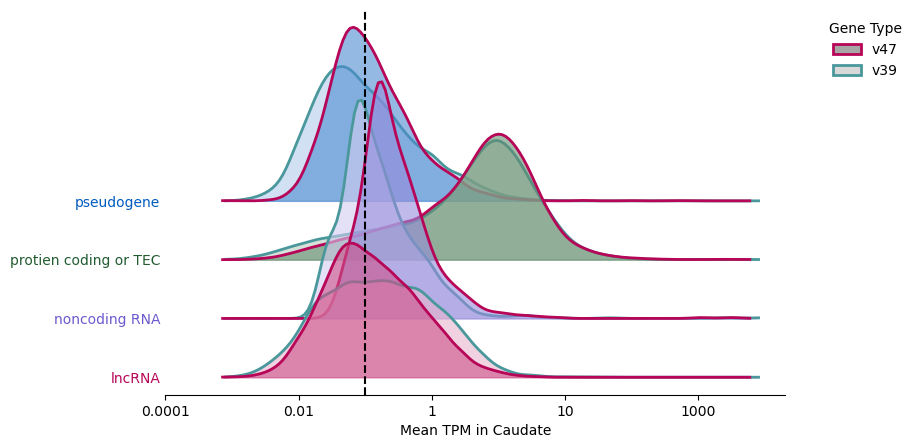

In [226]:
pretty_ylabels = [label.replace('_', ' ') for label in ridgeline_grouped_v10['gene_type_grouped'].values]
ax = ridgeline([np.log10(tpm) for tpm in ridgeline_grouped_v10['tpm'].values], overlap=.75, fill='y', use_labels=True, labels=pretty_ylabels, colors=gene_type_colors_light, zorder=0, edgecolor='#4a989c')
ridgeline([np.log10(tpm) for tpm in ridgeline_grouped_v11['tpm'].values], overlap=.75, fill='y', use_labels=True, labels=pretty_ylabels, colors=gene_type_colors, ax=ax, zorder=.5,  edgecolor='#b70657')

ax.axvline(np.log10(tpm_cutoff), color='k', linestyle='--', zorder=10)
ax.set_xlabel('Mean TPM in Caudate')

ax.set_xticks([-4, -2, 0, 2, 4], labels=['0.0001', '0.01', '1', '10', '1000'])


# add a legend
handles = [plt.Rectangle((0, 0), 1, 1, facecolor=fc, edgecolor=ec, linewidth=2) for fc, ec in zip([alpha_blending('grey', .7), alpha_blending('grey', .3)], ['#b70657', '#4a989c'])]
labels = ['v47', 'v39']
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', title='Gene Type')
leg = plt.gca().get_legend()
leg.set_frame_on(False)

# make colors darker
for tick, color in zip(ax.yaxis.get_major_ticks(), [gene_type_pal[gene_type] for gene_type in ridgeline_grouped_v10['gene_type_grouped'].values]):
    tick.label1.set_color(color)

plt.show()


#### scatterplot of quantification in one vs the other

In [273]:
mean_tpm_combined = pd.merge(left=v10_mean_tpm, right=v11_mean_tpm, on='gene_id', suffixes=['_v10', '_v11'], how='right')
# fill with 1e-10 for ones that don't exist
mean_tpm_combined[['tpm_v10', 'tpm_v11']] = mean_tpm_combined[['tpm_v10', 'tpm_v11']].fillna(1e-7)
# fill with 1e-5 for ones that exist but weren't found
mean_tpm_combined[['tpm_v10', 'tpm_v11']] = mean_tpm_combined[['tpm_v10', 'tpm_v11']].replace(0, 1e-5)

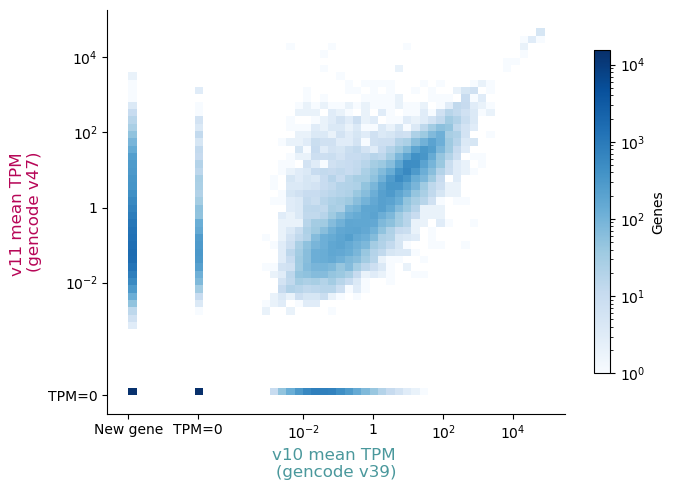

In [292]:
fig, ax = plt.subplots(figsize=(7,5))
sns.histplot(mean_tpm_combined, x='tpm_v10', y='tpm_v11', bins=50, norm=LogNorm(), vmin=None, vmax=None, cbar=True, log_scale=True, cmap=sns.color_palette("Blues", as_cmap=True), ax=ax, cbar_kws={'shrink':.8, 'label':'Genes'})

ax.set_xlabel('v10 mean TPM \n(gencode v39)', color='#4a989c', fontsize=12)
ax.set_ylabel('v11 mean TPM \n(gencode v47)', color='#b70657', fontsize=12)

ax.set_xticks([1e-7, 1e-5, 1e-2, 1, 1e2, 1e4], labels=['New gene', 'TPM=0', r'$10^{-2}$', 1, r'$10^{2}$', r'$10^{4}$'])
ax.set_yticks([1e-5, 1e-2, 1, 1e2, 1e4], labels=['TPM=0', r'$10^{-2}$', 1, r'$10^{2}$', r'$10^{4}$'])

ax.spines[['top', 'right']].set_visible(False)
fig.tight_layout()

In [ ]:
'})

ax.set_xlabel('v10 mean TPM', color='#4a989c', fontsize=12)
ax.set_ylabel('v11 mean TPM', color='#b70657', fontsize=12)

ax.set_xticks([1e-7, 1e-5, 1e-2, 1, 1e2, 1e4], labels=['New gene', 'TPM=0', r'$10^{-2}$', 1, r'$10^{2}$', r'$10^{4}$'])
ax.set_yticks([1e-5, 1e-2, 1, 1e2, 1e4], labels=['TPM=0', r'$10^{-2}$', 1, r'$10^{2}$', r'$10^{4}$'])

ax.spines[['top', 'right']].set_visible(False)
fig.tight_layout()